In [79]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import condition , seed , trace

from einops import rearrange

import optax
from tqdm import tqdm

import blackjax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

import jax_galsim as galsim
import galsim as gs

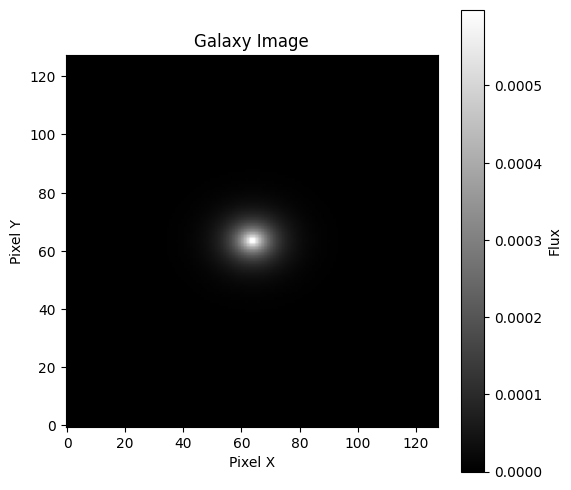

In [80]:
hlr = 1.2
flux = .1
n = 1.0
e1 = 0.1
e2 = 0.1
g1 = 0.05
g2 = -0.05

gal = gs.Sersic(n=n, half_light_radius=hlr, flux=flux)
gal = gal.shear(e1=e1, e2=e2)
gal = gal.shear(g1=g1, g2=g2)

# Generate a galaxy image
Npx = 128
pixel_scale = 0.15
fov_size = Npx * pixel_scale / 3600 # in degrees

# image
im_gal = gal.drawImage(nx=Npx, ny=Npx, scale=pixel_scale).array

# Plot the galaxy image
plt.figure(figsize=(6, 6))
plt.imshow(im_gal, origin='lower', cmap='gray')
plt.colorbar(label='Flux')
plt.title('Galaxy Image')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

def draw_galaxy(hlr, flux, n, e1, e2, g1, g2, Npx, pixel_scale):
    # Create the galaxy profile
    gal = gs.Sersic(n=n, half_light_radius=hlr, flux=flux)
    
    # Apply intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)
    
    # Apply shear
    gal = gal.shear(g1=g1, g2=g2)
    
    # Draw the galaxy image
    im_gal = gal.drawImage(nx=Npx, ny=Npx, scale=pixel_scale).array
    
    return im_gal



In [81]:
n_list = [0.5, 0.7, 1.0, 1.5, 2.0, 4.0]

galaxy_images = np.array([draw_galaxy(hlr, flux, n, e1, e2, g1, g2, Npx, pixel_scale) for n in n_list])

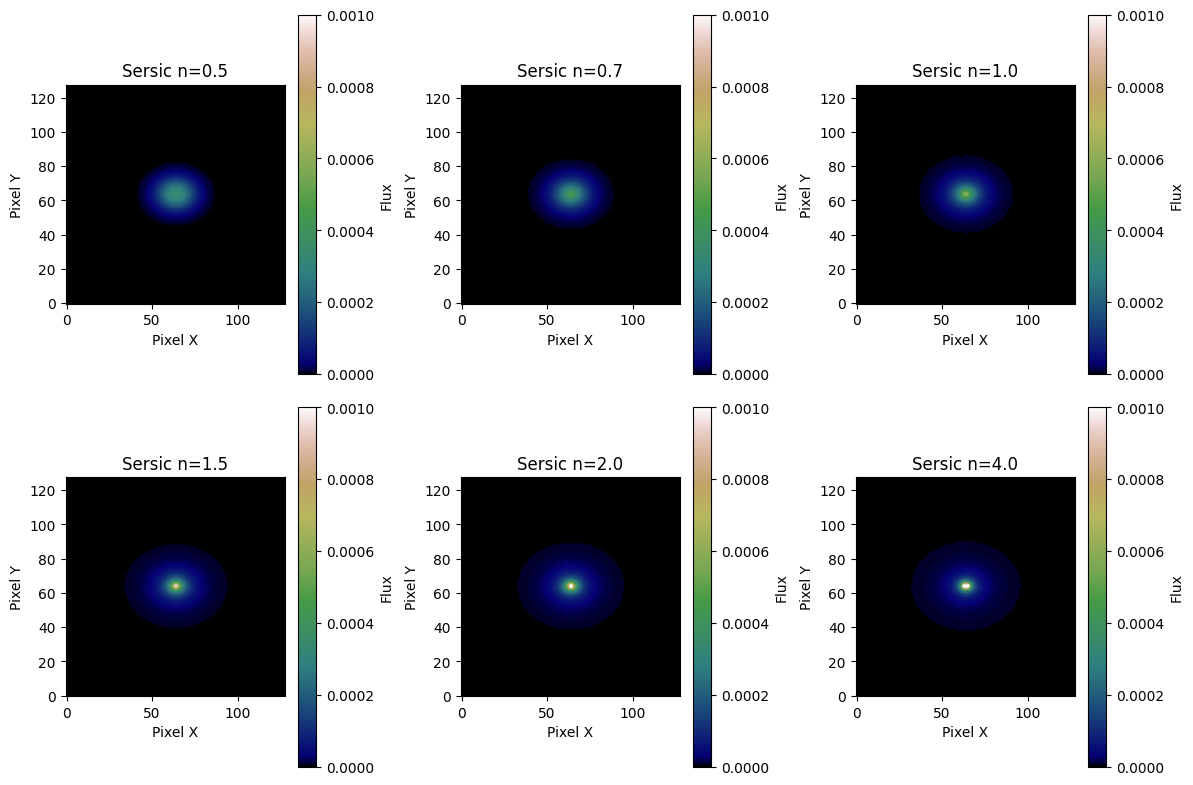

In [82]:
plt.figure(figsize=(12, 8))
for i, n in enumerate(n_list):
    plt.subplot(2, 3, i + 1)
    plt.imshow(galaxy_images[i], origin='lower', cmap='gist_earth', vmin=0, vmax=0.001)
    plt.title(f'Sersic n={n}')
    plt.colorbar(label='Flux')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()

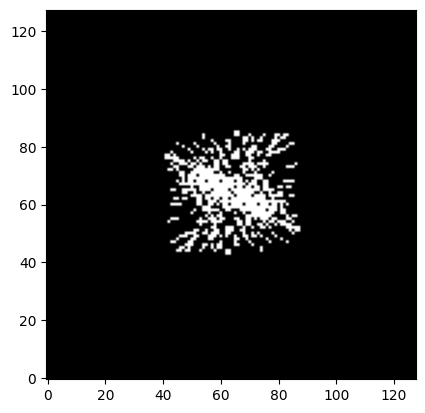

In [110]:
# Radio PSF
import argosim
import argosim.antenna_utils
import argosim.imaging_utils
# antenna = argosim.antenna_utils.y_antenna_arr(n_antenna=10, r=25e3)
# antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=80, E_lim=50e3, N_lim=50e3)
# antenna = argosim.antenna_utils.uni_antenna_array(n_antenna_E=10, n_antenna_N=4, E_lim=1e3, N_lim=3e3)
antenna = argosim.antenna_utils.random_antenna_arr(n_antenna=20, E_lim=50e3, N_lim=50e3, seed=333)
b_enu = argosim.antenna_utils.get_baselines(antenna)
track, _ = argosim.antenna_utils.uv_track_multiband(b_ENU=b_enu, track_time=10, n_times=2, f=1.4e9, df=1e8, n_freqs=2)
mask, _ = argosim.imaging_utils.grid_uv_samples(track, sky_uv_shape=(Npx, Npx), fov_size=(fov_size, fov_size))
# mask = np.ones_like(mask)
uv_pos = np.where(np.abs(mask) > 0.)
plt.imshow(np.abs(mask), origin='lower', cmap='gray')

In [111]:
def draw_radio_galaxy(hlr, flux, n, e1, e2, g1, g2, uv_pos, Npx, pixel_scale):
    
    gal = gs.Sersic(n=n, half_light_radius=hlr, flux=flux)
    
    # intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)

    # cosmic shear
    gal = gal.shear(g1=g1,g2=g2)

     # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=2 * np.pi / (Npx * pixel_scale))
    
    # Add noise
    gal_kimage = gal_kimage.array 
    
    # Sample the visibilities
    vis = gal_kimage[uv_pos]

    image_uv = np.zeros((Npx, Npx), dtype=np.complex128)
    image_uv[uv_pos] = vis

    gal_image = np.abs(np.fft.ifftshift(np.fft.ifft2(image_uv)))

    return gal_image

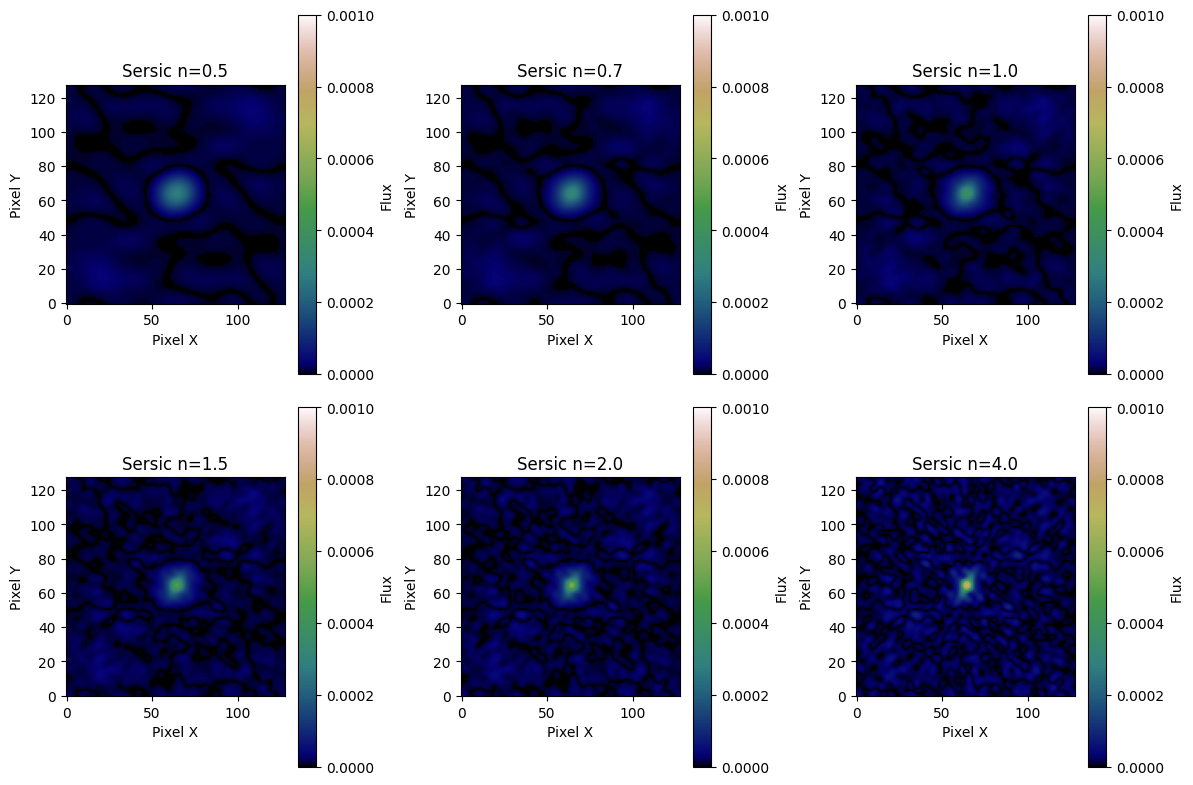

In [112]:
galaxy_images = np.array([draw_radio_galaxy(hlr, flux, n, e1, e2, g1, g2, uv_pos, Npx, pixel_scale) for n in n_list])
plt.figure(figsize=(12, 8))
for i, n in enumerate(n_list):
    plt.subplot(2, 3, i + 1)
    plt.imshow(galaxy_images[i], origin='lower', cmap='gist_earth', vmin=0, vmax=0.001)
    plt.title(f'Sersic n={n}')
    plt.colorbar(label='Flux')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()

In [113]:
def draw_radio_exp_galaxy(hlr, flux, e1, e2, g1, g2, uv_pos, Npx, pixel_scale):
    # Create the galaxy profile
    gal = galsim.Exponential(half_light_radius=hlr, flux=flux)
    
    # Apply intrinsic ellipticity
    gal = gal.shear(e1=e1, e2=e2)
    
    # Apply shear
    gal = gal.shear(g1=g1, g2=g2)
    
    # Convert to Fourier space
    gal_kimage = gal.drawKImage(nx=Npx, ny=Npx, scale=2 * np.pi / (Npx * pixel_scale))
    
    # Get array
    gal_kimage = np.array(gal_kimage.array)

    # Sample the visibilities
    vis = gal_kimage[uv_pos]

    image_uv = np.zeros((Npx, Npx), dtype=np.complex128)
    image_uv[uv_pos] = vis

    gal_image = np.abs(np.fft.ifftshift(np.fft.ifft2(image_uv)))

    return gal_image

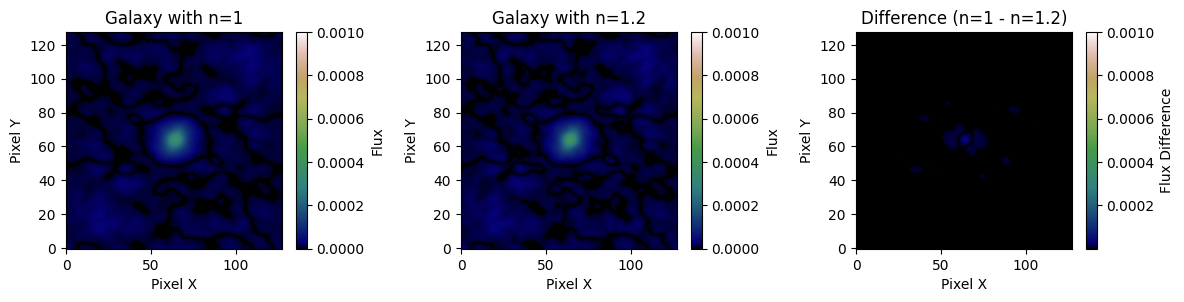

In [114]:
gal_exp = draw_radio_exp_galaxy(hlr, flux, e1, e2, g1, g2, uv_pos, Npx, pixel_scale)
gal_exp_approx = draw_radio_galaxy(hlr, flux, 1.2, e1, e2, g1, g2, uv_pos, Npx, pixel_scale)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(gal_exp, origin='lower', cmap='gist_earth', vmin=0, vmax=0.001)
plt.title('Galaxy with n=1')
plt.colorbar(label='Flux')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.subplot(1, 3, 2)
plt.imshow(gal_exp_approx, origin='lower', cmap='gist_earth', vmin=0, vmax=0.001)
plt.title('Galaxy with n=1.2')
plt.colorbar(label='Flux')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(gal_exp - gal_exp_approx), origin='lower', cmap='gist_earth', vmax=0.001)
plt.title('Difference (n=1 - n=1.2)')
plt.colorbar(label='Flux Difference')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()